In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data from Excel file
data = pd.read_excel('VIJ-VIZ-TIR.xlsx')
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

# Remove rows with missing values (if desired)
data = data.dropna()

# Check for and remove duplicates (if desired)
data = data.drop_duplicates()

# Outlier detection and handling (you can customize this)
from scipy import stats
z_scores = np.abs(stats.zscore(data[['d2m', 'blh', 'cp', 'cin','totalx']]))
threshold = 3
outliers = (z_scores > threshold).all(axis=1)
data = data[~outliers]
# Split data into features (X) and target (y)
X = data[['d2m', 'blh', 'cp', 'cin']].values
y = data['totalx'].values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the ANN model
from tensorflow.keras.layers import Dropout

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)  # Output layer for regression
])
from tensorflow.keras.optimizers import schedules

initial_learning_rate = 0.001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1500, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}') 

Missing Values:
SL NO      1
year       1
month      1
day        1
time       1
name       1
lat        1
lon        1
totalx     1
u10        0
v10        0
d2m        0
t2m        0
blh        0
cape       0
cin        0
cp         0
kx         0
slhf       0
ssr        0
sp         0
sshf       0
ssrdc      0
ssrd       0
tcc        0
tp         0
swvl1      0
p84.162    0
dtype: int64
Epoch 1/1500
34/34 [==============================] - 2s 20ms/step - loss: 2015.5070 - mae: 44.6257 - val_loss: 1761.3954 - val_mae: 41.7029
Epoch 2/1500
34/34 [==============================] - 0s 14ms/step - loss: 973.0066 - mae: 28.0592 - val_loss: 119.5876 - val_mae: 7.9728
Epoch 3/1500
34/34 [==============================] - 1s 15ms/step - loss: 291.4834 - mae: 12.3714 - val_loss: 69.4469 - val_mae: 6.6024
Epoch 4/1500
34/34 [==============================] - 0s 13ms/step - loss: 209.9379 - mae: 11.0785 - val_loss: 56.3124 - val_mae: 6.0033
Epoch 5/1500
34/34 [==============================] - 

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import schedules

# Load data from Excel file
data = pd.read_excel('VIJ-VIZ-TIR.xlsx')

# Assuming 'totalx' is the target variable to be predicted
target_variable = 'totalx'

# Filter data for the relevant columns and months (3, 4, 5)
filtered_data = data[['d2m', 'blh', 'cp', 'cin','cape', 'kx',"tp",target_variable]].copy()
filtered_data = filtered_data[data['month'].isin([3, 4, 5])]

# Split data into features (X) and target (y)
X = filtered_data[['d2m', 'blh', 'cp', 'cin' , 'cape', 'kx', 'tp']].values
y = filtered_data[target_variable].values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Save the best model during training
checkpoint = ModelCheckpoint('best_nn_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Use early stopping to prevent overfitting and find the optimal number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping], verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')


Epoch 1/200
32/34 [===========================>..] - ETA: 0s - loss: 1499.1919 - mae: 37.0544
Epoch 1: val_loss improved from inf to 221.02782, saving model to best_nn_model.h5
34/34 [==============================] - 3s 23ms/step - loss: 1434.2559 - mae: 35.8018 - val_loss: 221.0278 - val_mae: 11.8784
Epoch 2/200
 5/34 [===>..........................] - ETA: 0s - loss: 287.3745 - mae: 13.3724

/home/fitzingout/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/34 [===========================>..] - ETA: 0s - loss: 254.1404 - mae: 12.0259
Epoch 2: val_loss improved from 221.02782 to 79.11275, saving model to best_nn_model.h5
34/34 [==============================] - 1s 17ms/step - loss: 247.8303 - mae: 11.8418 - val_loss: 79.1127 - val_mae: 6.9761
Epoch 3/200
33/34 [============================>.] - ETA: 0s - loss: 156.9520 - mae: 9.6517
Epoch 3: val_loss improved from 79.11275 to 56.89703, saving model to best_nn_model.h5
34/34 [==============================] - 1s 18ms/step - loss: 156.4290 - mae: 9.6546 - val_loss: 56.8970 - val_mae: 5.8111
Epoch 4/200
34/34 [==============================] - ETA: 0s - loss: 127.4347 - mae: 8.8360
Epoch 4: val_loss improved from 56.89703 to 39.69924, saving model to best_nn_model.h5
34/34 [==============================] - 1s 16ms/step - loss: 127.4347 - mae: 8.8360 - val_loss: 39.6992 - val_mae: 4.7266
Epoch 5/200
31/34 [==========================>...] - ETA: 0s - loss: 115.4426 - mae: 8.2649
Epoch 5: va

In [28]:
# Make predictions for new input data
new_d2m = 296.907
new_blh = 461.283  
new_cp = 0.0000363533
new_cin = 202.997
new_cape = 1268.34
new_kx = 29.931
new_tp = 0.0000367388

# Create an array with the new input data
new_data = np.array([[new_d2m,new_blh, new_cp, new_cin , new_cape, new_kx, new_tp]])

# Standardize the new input data using the same scaler used during training
new_data = scaler.transform(new_data)  # Standardize the new input data

# Make predictions for the new input data
predicted_totalx = model.predict(new_data)

print(f'Total x: {predicted_totalx[0][0]}')
model.save('thundermodel.h5')


1/1 [==============================] - 0s 136ms/step
Total x: 42.50023651123047


/home/fitzingout/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 4ms/step
Mean Squared Error: 7.0330
Mean Absolute Error: 2.1131
R^2: 0.6555


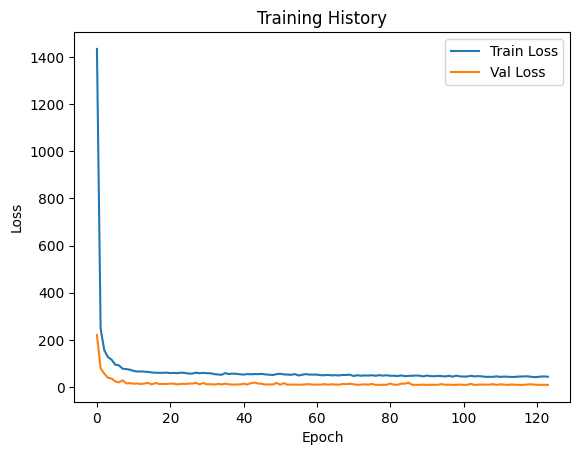

In [29]:
# now error calculation
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2: {r2:.4f}')

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
#now lets make a new excel file and there we will put the predicted values input and the actual values
y_pred = y_pred.flatten()
y_test = y_test.flatten()
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.to_excel('predicted.xlsx', index=False)
print(df)


      Actual  Predicted
0    49.8097  48.890110
1    47.9515  48.319752
2    49.1195  48.195782
3    46.8247  46.186638
4    45.7672  44.602711
..       ...        ...
672  46.6823  44.923420
673  51.4087  50.169212
674  40.7642  43.900856
675  45.7438  45.915756
676  45.9021  46.137039

[677 rows x 2 columns]


In [31]:
#now for second sheet ie vizag
data = pd.read_excel('VIJ-VIZ-TIR.xlsx', sheet_name=1)
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

# Remove rows with missing values (if desired)
data = data.dropna()

# Check for and remove duplicates (if desired)
data = data.drop_duplicates()

# Outlier detection and handling (you can customize this)
from scipy import stats
z_scores = np.abs(stats.zscore(data[['d2m', 'blh', 'cp', 'cin','totalx']]))
threshold = 3
outliers = (z_scores > threshold).all(axis=1)
data = data[~outliers]
# Split data into features (X) and target (y)
X = data[['d2m', 'blh', 'cp', 'cin']].values
y = data['totalx'].values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')



Missing Values:
SL NO      1
year       1
month      1
day        1
time       1
name       1
lat        1
lon        1
totalx     1
u10        0
v10        0
d2m        0
t2m        0
blh        0
cape       0
cin        0
cp         0
kx         0
slhf       0
ssr        0
sp         0
sshf       0
ssrdc      0
ssrd       0
tcc        0
tp         0
swvl1      0
p84.162    0
dtype: int64
Epoch 1/150
34/34 [==============================] - 2s 17ms/step - loss: 1969.4816 - mae: 44.1302 - val_loss: 1685.1945 - val_mae: 40.7266
Epoch 2/150
30/34 [=========================>....] - ETA: 0s - loss: 987.5235 - mae: 29.0289 

KeyboardInterrupt: 

In [ ]:
# Make predictions for new input data
new_d2m = 296.907
new_blh = 461.283
new_cp = 0.0000363533
new_cin = 202.997

# Create an array with the new input data
new_data = np.array([[new_d2m,new_blh, new_cp, new_cin]])

# Standardize the new input data using the same scaler used during training
new_data = scaler.transform(new_data)  # Standardize the new input data

# Make predictions for the new input data
predicted_totalx = model.predict(new_data)

print(f'Total x: {predicted_totalx[0][0]}')
model.save('vizagmodel.h5')



In [ ]:
#error calculation
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2: {r2:.4f}')



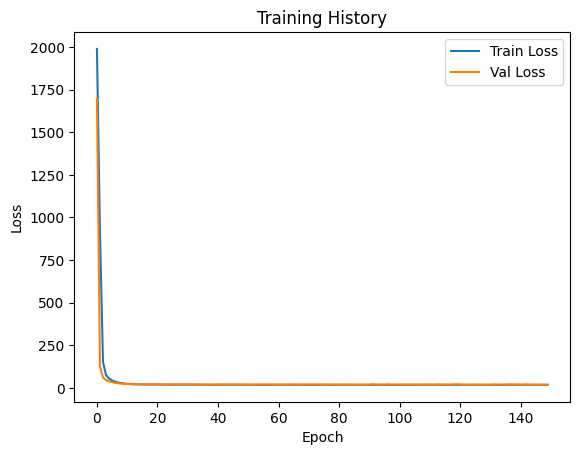

In [12]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [14]:
#now lets make a new excel file and there we will put the predicted values input and the actual values
y_pred = y_pred.flatten()
y_test = y_test.flatten()
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.to_excel('predictedvizag.xlsx', index=False)
print(df)


      Actual  Predicted
0    49.4816  45.277981
1    43.2290  47.306725
2    48.1822  46.117512
3    42.2000  45.279049
4    42.0423  42.801773
..       ...        ...
672  49.0324  44.189243
673  44.8565  47.289932
674  46.0146  42.471268
675  49.8840  44.305206
676  42.9741  45.896988

[677 rows x 2 columns]


In [2]:
#now for third sheet ie tirupati
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import schedules

# Load data from Excel file
data = pd.read_excel('VIJ-VIZ-TIR.xlsx', sheet_name=2)

# Assuming 'totalx' is the target variable to be predicted
target_variable = 'totalx'

# Filter data for the relevant columns and months (3, 4, 5)
filtered_data = data[['d2m', 'blh', 'cp', 'cin','cape', 'kx',"tp",target_variable]].copy()
filtered_data = filtered_data[data['month'].isin([3, 4, 5])]

# Split data into features (X) and target (y)
X = filtered_data[['d2m', 'blh', 'cp', 'cin' , 'cape', 'kx', 'tp']].values
y = filtered_data[target_variable].values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Save the best model during training
checkpoint = ModelCheckpoint('best_nn_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Use early stopping to prevent overfitting and find the optimal number of epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping], verbose=1)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}, Test MAE: {mae:.4f}')





2024-02-20 09:16:40.208218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 09:16:40.208440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 09:16:40.277201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 09:16:40.449296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 09:16:42.476133: W tensorflow/compiler/tf2

Epoch 1/200


2024-02-20 09:16:53.874126: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ffa2077af00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 09:16:53.874262: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-02-20 09:16:53.898048: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 09:16:53.960650: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708400814.176980    2255 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/68 [===========================>..] - ETA: 0s - loss: 313.5804 - mae: 13.7622
Epoch 1: val_loss improved from inf to 59.52577, saving model to best_nn_model.h5
68/68 [==============================] - 8s 22ms/step - loss: 305.9420 - mae: 13.5626 - val_loss: 59.5258 - val_mae: 5.0280
Epoch 2/200
 6/68 [=>............................] - ETA: 0s - loss: 124.1728 - mae: 8.7475

/home/fitzingout/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/68 [============================>.] - ETA: 0s - loss: 149.6391 - mae: 9.4415
Epoch 2: val_loss did not improve from 59.52577
68/68 [==============================] - 1s 18ms/step - loss: 153.3694 - mae: 9.5787 - val_loss: 210.8697 - val_mae: 12.7331
Epoch 3/200
64/68 [===========================>..] - ETA: 0s - loss: 114.7114 - mae: 8.3926
Epoch 3: val_loss improved from 59.52577 to 40.60204, saving model to best_nn_model.h5
68/68 [==============================] - 1s 18ms/step - loss: 113.0254 - mae: 8.3259 - val_loss: 40.6020 - val_mae: 5.2568
Epoch 4/200
66/68 [============================>.] - ETA: 0s - loss: 105.8429 - mae: 8.0330
Epoch 4: val_loss improved from 40.60204 to 39.89172, saving model to best_nn_model.h5
68/68 [==============================] - 1s 19ms/step - loss: 105.1130 - mae: 8.0081 - val_loss: 39.8917 - val_mae: 4.9434
Epoch 5/200
66/68 [============================>.] - ETA: 0s - loss: 98.5206 - mae: 7.7714
Epoch 5: val_loss did not improve from 39.89172
68/6

In [3]:
# Make predictions for new input data
new_d2m = 296.907
new_blh = 461.283
new_cp = 0.0000363533
new_cin = 202.997
new_cape = 1268.34
new_kx = 29.931
new_tp = 0.0000367388


# Create an array with the new input data
new_data = np.array([[new_d2m,new_blh, new_cp, new_cin, new_cape, new_kx, new_tp]])

# Standardize the new input data using the same scaler used during training
new_data = scaler.transform(new_data)  # Standardize the new input data

# Make predictions for the new input data
predicted_totalx = model.predict(new_data)

print(f'Total x: {predicted_totalx[0][0]}')
model.save('tirupatimodel.h5')

1/1 [==============================] - 0s 366ms/step
Total x: 43.3357048034668


/home/fitzingout/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 5ms/step
Mean Squared Error: 7.9054
Mean Absolute Error: 2.1535
R^2: 0.6506


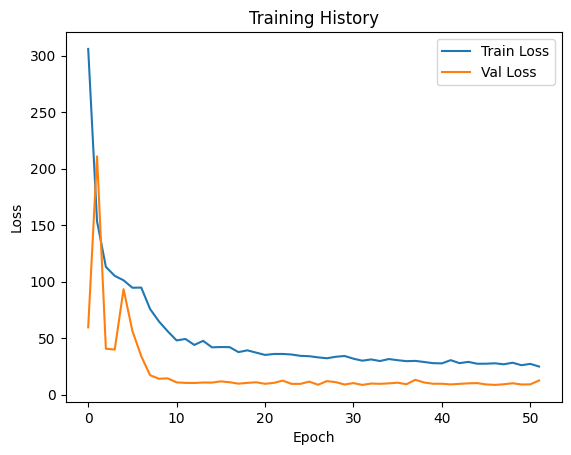

In [4]:
#error calculation
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2: {r2:.4f}')


# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
#now lets make a new excel file and there we will put the predicted values input and the actual values
y_pred = y_pred.flatten()
y_test = y_test.flatten()
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.to_excel('predictedtirupati.xlsx', index=False)
print(df)
model.summary()


      Actual  Predicted
0    47.3505  49.334820
1    44.2619  42.683563
2    48.8539  47.869026
3    41.9240  40.782913
4    39.6246  38.483086
..       ...        ...
672  47.0852  39.913227
673  37.7878  37.774666
674  41.7528  42.129433
675  43.9274  46.304890
676  43.8867  42.483822

[677 rows x 2 columns]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4096      
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout

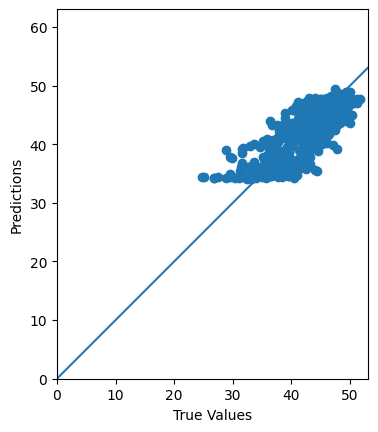

In [6]:
#scatter plot
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()



In [ ]:
#rmse and date and temperature graph
